In [1]:
pip install caer canaro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2,

In [2]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

### Setting some basic constants, such as the used IMG_SIZE, required channels, and the path to the actual dataset

In [3]:
IMG_SIZE = (80,80) # the usual size of images in the simpsons dataset
channels = 1 # we do not require color in our images
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

Getting the top 10 datasets with most images

In [4]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))
    
# Sorting the dictionary in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

Getting the top 10 elements, storing it in the characters list

In [5]:
characters = [character[0] for i, character in enumerate(char_dict) if i < 10 ]
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

## Creating the training data

In [6]:
# Going through every folder in the char_path, looking for every element inside characters, 
# When it finds a 'homer_simpson' it will grab every photo and store it to train the model on
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)



[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.9768400192260742s
[INFO] At 1000 files
[INFO] 1454 files found in 0.29126477241516113s
[INFO] At 1000 files
[INFO] 1452 files found in 0.30327510833740234s
[INFO] At 1000 files
[INFO] 1354 files found in 0.22251152992248535s
[INFO] At 1000 files
[INFO] 1342 files found in 0.1977376937866211s
[INFO] At 1000 files
[INFO] 1291 files found in 0.16274547576904297s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0675954818725586s
[INFO] At 1000 files
[INFO] 1194 files found in 0.06188511848449707s
[INFO] At 1000 files
[INFO] 1193 files found in 0.06424689292907715s
[INFO] At 1000 files
[INFO] 1079 files found in 0.004279613494873047s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 37s


In [7]:
len(train)

13811

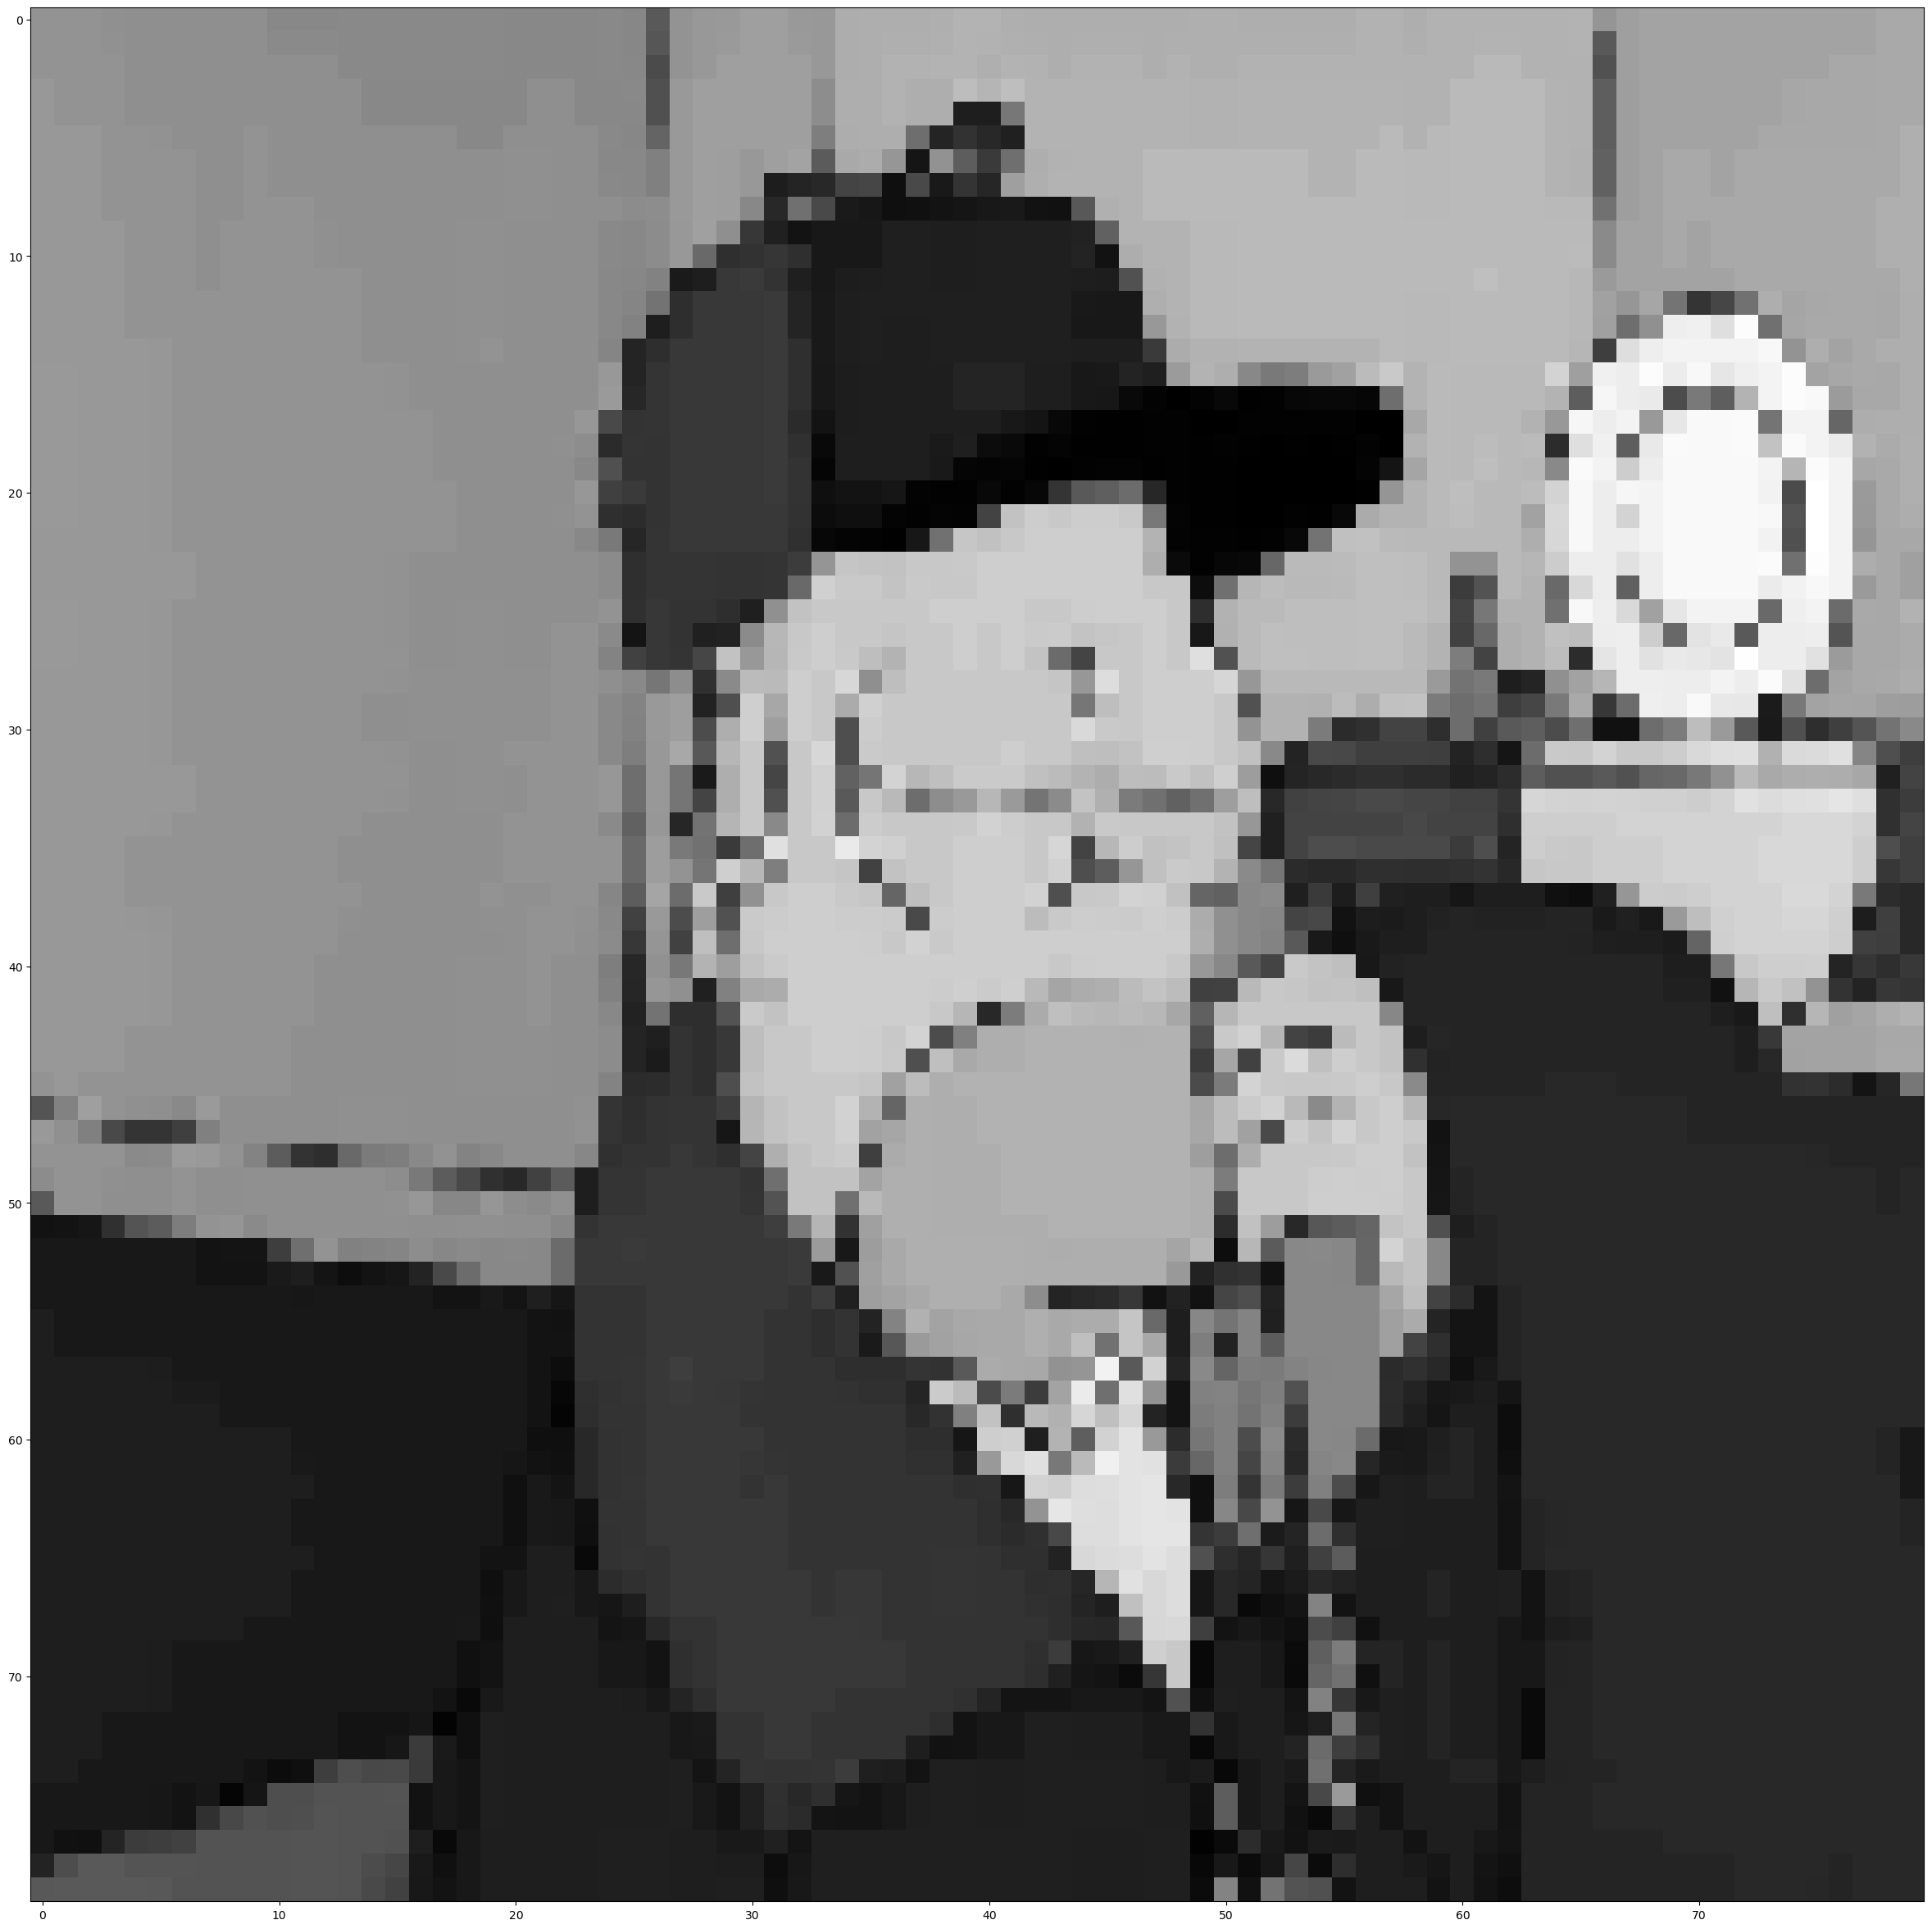

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

## Separating the training set into features and labels
Currently its just a list of a lot of lists inside them

In [9]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

## Normalizing the feature set
Normalizing the data to be in the range to (0,1) -> makes training way faster

In [10]:
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(featureSet)

labels = to_categorical(labels, len(characters))

## Creating a training and validation data

In [11]:
# Splitting the training and validation sets with the .2 val_ratio
# 20% goes to the validation set, the rest to the train set
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [12]:
del train
del featureSet
del labels
gc.collect()

21

## Creating the image data generator
An image generator that will synthesise new images from existing images, to randomize the network, makes it perform better

In [13]:
BATCH_SIZE = 32
EPOCHS = 10
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

## Creating the model
And also compiles the model so we can use it